In [1]:
from v1_likelihood.simulate_poisson import *

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting eywalker@10.28.0.34:3306


In [2]:
from itertools import  product, count

In [3]:
# make font exportable
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.0
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2.0
mpl.rcParams['ytick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

mpl.rcParams['xtick.minor.size'] = 1.0
mpl.rcParams['ytick.minor.size'] = 1.0

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['font.size'] = 6.0
mpl.rcParams['font.sans-serif'] = ['Liberation Sans']



tom_color = np.array([1, 1, 1]) * 0
leo_color = np.array([1, 1, 1]) * 0.5
tom_marker = '^'
leo_marker = 's'
cp = sns.color_palette("RdBu_r")

contrast_colors = sns.cubehelix_palette(12, start=0.5, rot=-.75)[2:]

c1_color = cp[-1]
c2_color = cp[0]

# Plot KLs

In [4]:
keys = TrainedNetKL().fetch('KEY')

best = keys[0]

In [32]:
poisson_kl = (FittedPoissonKL() & best).fetch1('fit_test_kl') / np.log(2)
cnn_kl = (TrainedNetKL() & best).fetch1('cnn_test_kl') / np.log(2)
df = pd.DataFrame({'cnn': cnn_kl, 'poisson': poisson_kl})

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


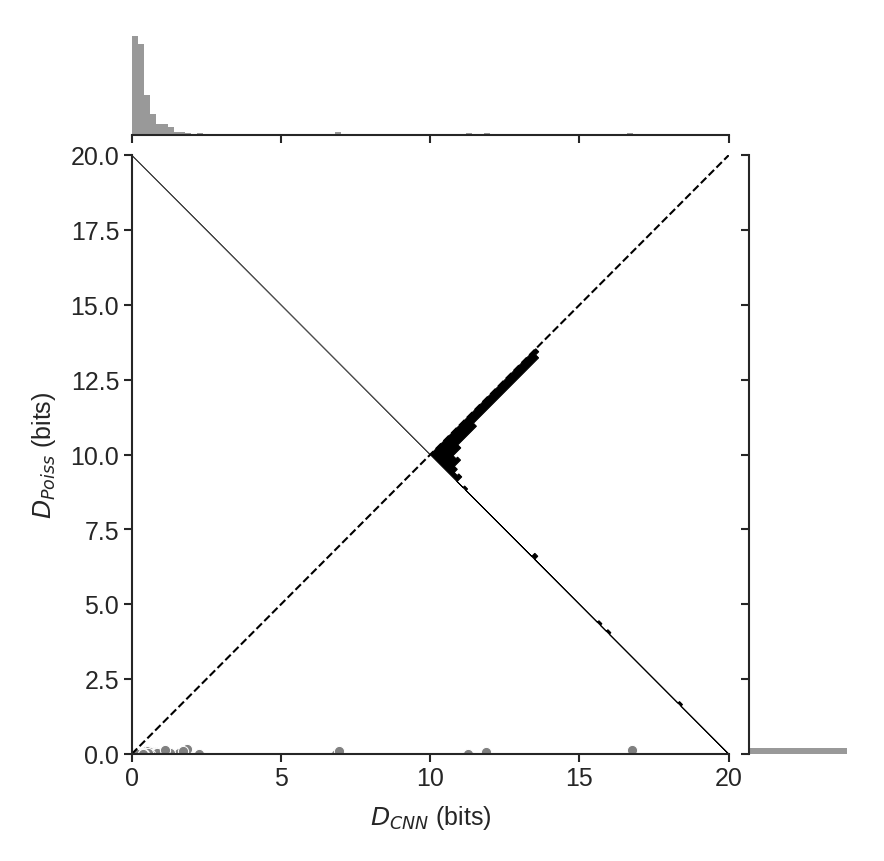

In [36]:
fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
markersize=4

jg = sns.JointGrid(x='cnn', y='poisson', size=3, data=df)
jg.plot_joint(plt.scatter, color=".5", edgecolor="white", s=6)
jg.plot_marginals(sns.distplot, bins=100, color='k', kde=False, hist_kws={'range':(0, 20)})

fig = plt.gcf()
ax = jg.ax_joint

x = cnn_kl
y = poisson_kl
h, e = np.histogram(x-y, range=(-20, 20), bins=200)
h = h/h.max() * 5
binc = (e[1:] + e[:-1])/2
X = np.vstack((binc, h))
phi = np.pi/4
R = np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]])

binw = np.diff(binc).mean()
idx = binc < 0
for i, c in zip([idx, ~idx], [ '0.3', 'k']):
    Y = X[:, i]
    bottom = np.stack([Y[1, :]]*2, axis=-1)
    top = np.stack([Y[0, :] - binw/2, Y[0, :] + binw/2], axis=-1) / np.sqrt(2)
    Y = np.stack([top, bottom])

    Y = Y.reshape([2, -1])
    tmp0 = np.array([[Y[0,-1], 0]])
    tmp = np.array([[Y[0,0], 0]])
    Y = np.hstack((tmp.T, Y, tmp0.T))
    Y = R @ Y + np.ones((2,1))* 10
    ax.fill(Y[0, :], Y[1, :], color=c)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel('$D_{CNN}$ (bits)', fontsize=fs, labelpad=labelpad)
ax.set_ylabel('$D_{Poiss}$ (bits)', fontsize=fs, labelpad=labelpad)
ax.tick_params(labelsize=fs, pad=pad)

x = np.linspace(0, 20)
ax.plot(x, x, '--k')

fig.set_dpi(300)
fig.savefig('figures/ext_fig02a.pdf')

In [26]:
gt_resp = (PoissonSimulation() & best).simulate_responses()
poiss_resp = (FittedPoissonScores() & best).response_summary()
rel = (PoissonTrainedModel() & best)
model = rel.load_model()
train_x, train_t, valid_x, valid_t, test_x, test_t = rel.get_dataset(keep_all=True)
train_x, train_t = Variable(train_x), Variable(train_t)

model.cuda()
model.eval()

delta, nbins, clip_outside = (BinConfig() & best).fetch1('bin_width', 'bin_counts', 'clip_outside')
delta = float(delta)
pv = (np.arange(nbins) - nbins // 2) * delta

set_types = ['train', 'valid', 'test']
set_x = [train_x, valid_x, test_x]

nlset = {}

for st, x in zip(set_types, set_x):
    gt_logl = gt_resp[st]['logl_f'](pv)
    gt_nl = np.exp(gt_logl)
    gt_nl = gt_nl / np.sum(gt_nl, axis=1, keepdims=True)
    
    poiss_logl = poiss_resp[st]['logl_f'](pv)
    poiss_nl = np.exp(poiss_logl)
    poiss_nl = poiss_nl / np.sum(poiss_nl, axis=1, keepdims=True)

    cnn_logl = model(x.cuda()).data.cpu().numpy()
    cnn_nl = np.exp(cnn_logl)
    cnn_nl = cnn_nl / np.sum(cnn_nl, axis=1, keepdims=True)
    
    eps = 1e-15
    cnn_kl = ((np.log(gt_nl + eps) - np.log(cnn_nl + eps)) * gt_nl).sum(axis=1)
    poiss_kl = ((np.log(gt_nl + eps) - np.log(poiss_nl + eps)) * gt_nl).sum(axis=1)
    nlset[st] = [gt_nl, cnn_nl, cnn_kl, poiss_nl, poiss_kl]

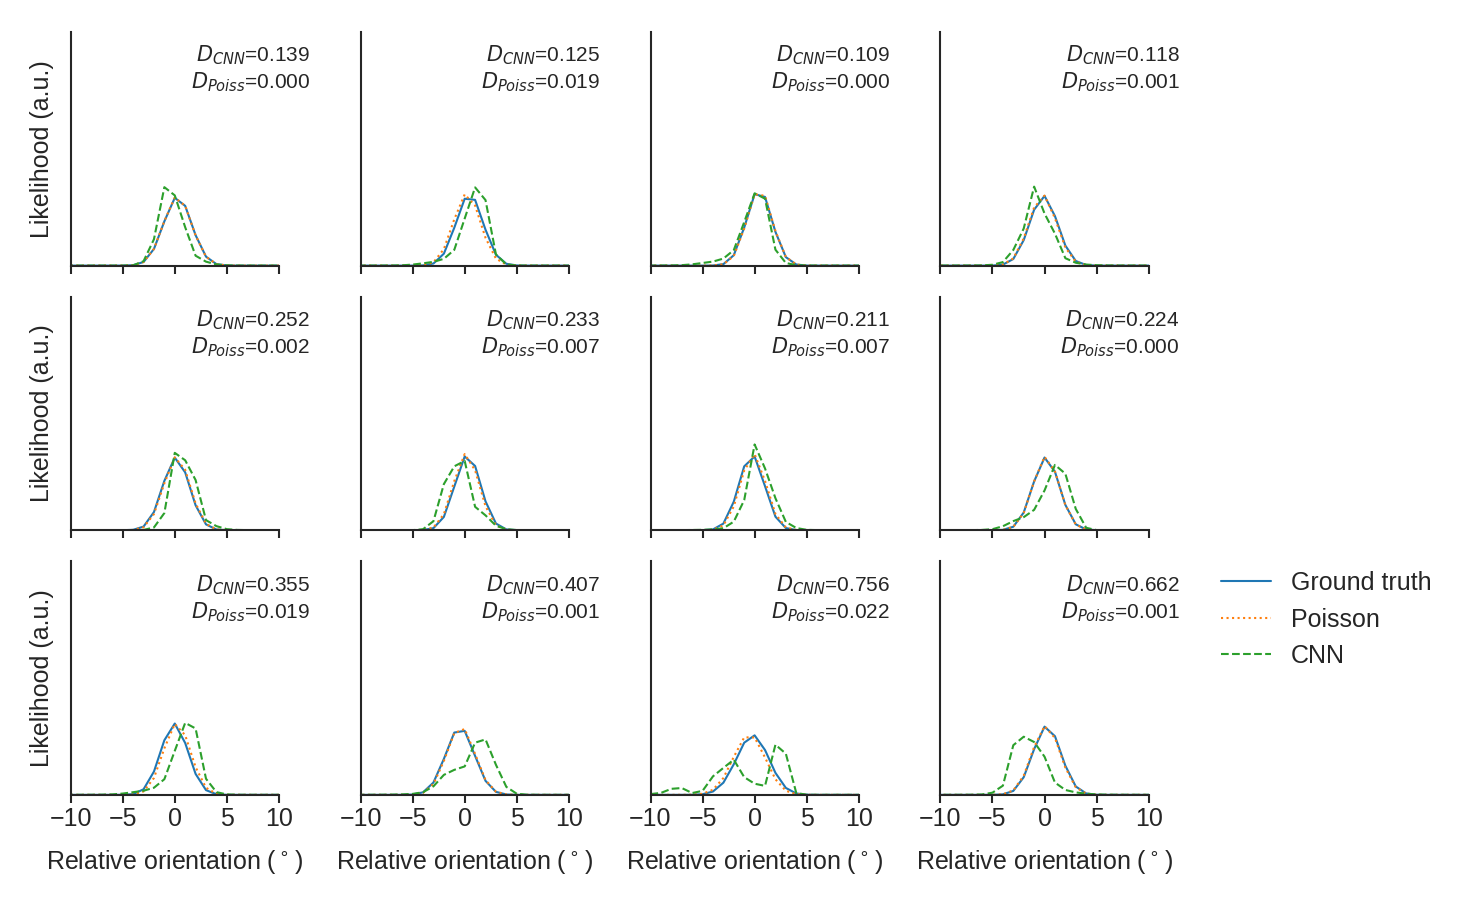

In [43]:
gt_nl, cnn_nl, cnn_kl, poiss_nl, poiss_kl = nlset['test']
order = np.argsort(cnn_kl)

fs = 6.0
offset = 0
trim = False
pad = 1
labelpad=3
markersize=4

n_rows = 3
samples = 4
fig, axs = plt.subplots(n_rows, samples, figsize=(4, 3), dpi=300, sharex=True, sharey=True)

strip = 100 / n_rows

np.random.seed(4395)

#perm = np.random.permutation(len(gt_nl))

i = 0
for row, ax_row in enumerate(axs):
    lb, ub = np.percentile(cnn_kl, [row*strip, (row+1)*strip])
    choices = np.where((cnn_kl >= lb) & (cnn_kl < ub))[0]
    sample_pos = np.random.choice(choices, samples)
    for col, ax, pos in zip(count(), ax_row, sample_pos):
        center = pv[np.argmax(gt_nl[pos])]
        pv_adj = pv - center
        ax.plot(pv_adj, gt_nl[pos], label='Ground truth')
        ax.plot(pv_adj, poiss_nl[pos], ':', label='Poisson')
        ax.plot(pv_adj, cnn_nl[pos], '--', label='CNN')
        label = '$D_{{CNN}}$={cnn:.3f}\n$D_{{Poiss}}$={poisson:.3f}'.format(cnn=cnn_kl[pos], poisson=poiss_kl[pos])
        ax.text(1.15, 0.95, label, fontsize=fs-1, transform=ax.transAxes, ha='right', va='top')
        ax.set_xlim([-10, 10])
        ax.set_ylim([0, 1])
        ax.set_xticks([-10, -5, 0, 5, 10])
        ax.tick_params(labelsize=fs, pad=pad)
        sns.despine(ax=ax)
        
        if col == 0:
            ax.set_ylabel('Likelihood (a.u.)', fontsize=fs)
            ax.set_yticks([])
            
        if row == n_rows-1:
            ax.set_xlabel(r'Relative orientation ($^\circ$)', fontsize=fs)
        
        i += 1
fig.tight_layout()
ax.legend(fontsize=fs, loc=(1.3, 0.5) )
fig.savefig('figures/ext_fig02b.pdf')